In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helpers as hp
import simulate as sim
import toy_problem_analytical as tpa

# Toy problem

Here we use backward Euler to simulate the temperature distribution over time in the can according to the conditions set out in the analytical solution (toy problem) section.

In [2]:
# User defined parameters
b0 = 150 # u(0,t)= b0 (boundary cond)
bL = 20 # u(L,t)= bL (boundary cond)
D = 0.01 # thermal diffusivity coefficient - in the liquid
a = 0 # heat transfer coefficient of liquid through container to air - for sink term along sides of can
T = 3 # final time 
L = 0.2 # Length (i.e. height) of the can
Nt_points = 2000    # number of timesteps
Nx_points = 100   # number of spaces in x

u_inf = bL # air temperature - for this problem we say that the temperature at end of rod is fixed at air temp

# Set initial condition
u0 = np.zeros(Nx_points)
u0[0] = b0
u0[1:] = bL*np.ones(Nx_points-1)


In [3]:
# initialise some helper functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

In [4]:
# run simulation
U = sim.simulate_dirichlet_sink(u0, lambda t: b0, D, T, Nt_points, L, Nx_points, 0)

We compare the numeric simulation to the analytic solution

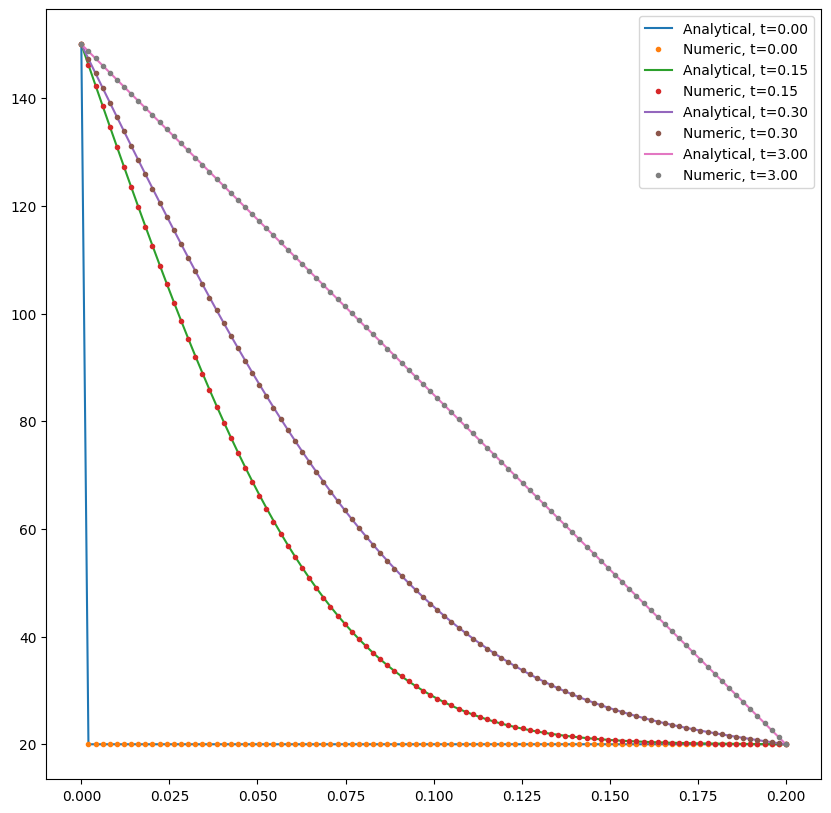

In [32]:
U_analyt = tpa.create_analytic_toy_fn(b0, bL, L, D)
x = np.linspace(0,L,Nx_points)

fig, ax = plt.subplots(figsize = (10,10))

for i in (0, Nt_points//20, Nt_points//10, Nt_points - 1):
    t = index_to_time(i)
    ax.plot(x, U_analyt(x, t), "-", label = f"Analytical, {t=:.2f}")
    ax.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
    

plt.legend()
plt.show()

## Time to heat

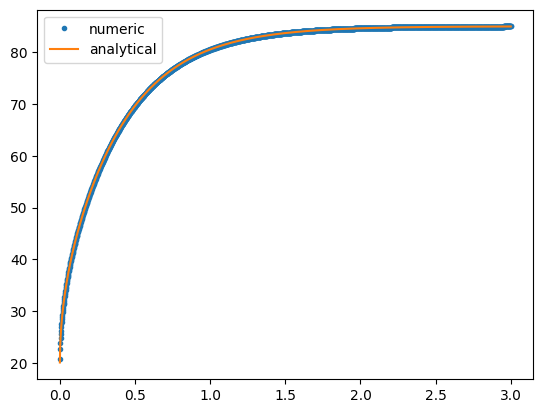

In [5]:
avg_temp_analytic = tpa.create_analytic_avg_temp(b0, bL, L, D)
avg_temp_numeric = sim.create_numeric_avtemp_fn(U, 1/(Nx_points - 1), time_to_index)

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.plot(t, avg_temp_analytic(t), "-", label = "analytical")
plt.legend()
plt.show()


In [36]:
num_tto80 = sim.time_to_temp(avg_temp_numeric(t), 80, index_to_time)
analyt_tto80 = sim.time_to_temp(avg_temp_analytic(t), 80, index_to_time)

print(f"{num_tto80=:.4f}, {analyt_tto80=:.4f}")

num_tto80=0.9575, analyt_tto80=0.9545


# Other

Newton cooling at top of can

In [ ]:
##  Newton cooling at top of can
##  Jack's Code
##  x and t parameters and BC conditions same as above
##  For re-used parameters, ie A_nct and U, added "_nct" for newton cooling at top

# Heat transfer coefficient and ambient temperature
a = 0.05
h = 0.1  # heat transfer coefficient for Newton cooling (top boundary)


# Initialize matrices for storing solutions
U_nct = np.zeros((Nx_points, Nt_points))

# Define the tridiagonal matrix A_nct for the backward Euler scheme
A_nct = np.zeros((Nx_points, Nx_points))
for i in range(1, Nx_points - 1):
    A_nct[i, i - 1] = -C
    A_nct[i, i + 1] = -C
    A_nct[i, i] = 1 + 2 * C

# Implement boundary conditions
A_nct[0, 0] = 1  # Dirichlet condition at the bottom
A_nct[Nx_points - 1, Nx_points - 1] = 1 + h * dt / dx  # Newton cooling at the top


# NOTE: Sets bottom of can from 150C to 950C
#       top of can dropping lower than 20C because of cooling
#       set b0 to 150 to see what happens here when Newton cooling added
#       currently can only see what happens at 950C in data; all in plot
#       What we can investigate: what happens when bottom held at 150C and cooling term varies

# Set different bottom boundary conditions for investigation
b0_values = np.arange(150, 1001, 100)  # Different constant boundary values at x = 0 (bottom of the can)

for b0 in b0_values:
    # Set initial conditions
    u_old = 20 * np.ones(Nx_points)  # Initial temperature at t = 0
    u_old[0] = b0  # Set bottom boundary condition
    U_nct[:, 0] = u_old[:]

    # Time-stepping loop for the backward Euler method
    for n in range(1, Nt_points):
        # Set the boundary values in vector b
        b = u_old.copy()
        b[0] = b0  # Constant bottom boundary condition
        b[-1] = u_old[-1] + h * dt * (u_inf - u_old[-1]) / dx  # Newton cooling boundary condition at the top


# NOTE: Don't think we were meant to do this as it's unstable!!! Workshop 2 notes 
    
        # U_nctpdate u by solving the matrix system A_nct * u_new = b
        u_new = np.linalg.solve(A_nct, b)
        u_new[1:Nx_points - 1] -= a * (u_old[1:Nx_points - 1] - u_inf)  # A_nctpply heat transfer to the surrounding air

        # U_nctpdate u_old before the next step
        u_old = u_new
        U_nct[:, n] = u_new

    # Plot the temperature distribution at the final time step
    t_final = Nt_points - 1
    plt.plot(x, U_nct[:, t_final], label=f"Temperature at t = {T}, b0 = {b0}")

plt.xlabel("Position along the can (x)")
plt.ylabel("Temperature (u)")
plt.title("Temperature distribution along the can at final time for different bottom boundary conditions")
plt.legend()
plt.grid(True)
plt.show()

Newton cooling at bottom of can

In [ ]:
##  Newton cooling at bottom of can
##  Jamie's Code
##  adapted code from Jack
##  x and t parameters and BC conditions same as above
##  h: Heat transfer coefficient for Newton cooling at the bottom boundary. NB: Material dependent! 
##      SHOULD BE SAME THROUGHOUT CODE UNLESS WE CHANGE CAN MATERIALS
##  For re-used parameters, ie A and U, added "_ncb" for newton cooling at top
##  RESOURCE: https://uk.mathworks.com/help/simscape/ug/heat-conduction-through-iron-rod.html

# Initialize matrices for storing solutions
U_ncb = np.zeros((Nx_points, Nt_points))

# Define the tridiagonal matrix A_ncb for the backward Euler scheme
A_ncb = np.zeros((Nx_points, Nx_points))
for i in range(1, Nx_points - 1):
    A_ncb[i, i - 1] = -C
    A_ncb[i, i + 1] = -C
    A_ncb[i, i] = 1 + 2 * C

# Implement boundary conditions
A_ncb[0, 0] = 1 + h * dt / dx  # Newton cooling at bottom
A_ncb[Nx_points - 1, Nx_points - 1] = 1  # Dirichlet condition at top


# NOTE: Sets bottom of can from 150C to 950C
#       top of can dropping lower than 20C because of cooling
#       set b0 to 150 to see what happens here when Newton cooling added
#       currently can only see what happens at 950C
#       What we can investigate: what happens when bottom held at 150C and cooling term varies

# Set different bottom boundary conditions for investigation
b0_values = np.arange(150, 1001, 100)  # Different constant boundary values at x = 0 (bottom of the can)

for b0 in b0_values:
    # Set initial conditions
    u_old = 20 * np.ones(Nx_points)  # Initial temperature at t = 0
    u_old[0] = b0  # Set bottom boundary condition
    U_ncb[:, 0] = u_old[:]

    # Time-stepping loop for the backward Euler method
    for n in range(1, Nt_points):
        # Set the boundary values in vector b
        b = u_old.copy()
        #b[0] = b0  # Constant bottom boundary condition
        b[0] = u_old[0] + h * dt * (u_inf - u_old[0]) / dx  # Newton cooling boundary condition at the bottom

        # U_ncbpdate u by solving the matrix system A_ncb * u_new = b
        u_new = np.linalg.solve(A_ncb, b)
        u_new[1:Nx_points - 1] -= a * (u_old[1:Nx_points - 1] - u_inf)  # A_ncbpply heat transfer to the surrounding air

        # U_ncbpdate u_old before the next step
        u_old = u_new
        U_ncb[:, n] = u_new

    # Plot the temperature distribution at the final time step
    t_final = Nt_points - 1
    plt.plot(x, U_ncb[:, t_final], label=f"Temperature at t = {T}, b0 = {b0}")

plt.xlabel("Position along the can (x)")
plt.ylabel("Temperature (u)")
plt.title("Temperature distribution along the can at final time for different bottom boundary conditions")
plt.legend()
plt.grid(True)
plt.show()
